# Modeling void fraction in fluid channel using cross-sectional disks

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import splrep
from scipy.interpolate import splev

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, title='', size=None):
    """Creates a custom plot configuration to make graphs look nice.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

def get_channel(channel_shape):
    """Return list of all index coordinates of the empty channel."""
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel_shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel_coords

def get_bubbles(model_info, channel):
    """Get random bubble radii and center coordinates."""
    # get number of bubbles and radii limits
    num = model_info['num_of_bubbles_to_try']
    min_rad = model_info['min_rad_um']/model_info['um_per_pixel'],
    max_rad = model_info['max_rad_um']/model_info['um_per_pixel']
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.clip(rad_list, min_rad, max_rad)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {
        'rad': rad_list,
        'rad_squared': np.square(rad_list),
        'x': x_list,
        'y': y_list}

def single_cross_sec(x, c, rx, ry):
    """
    Create a disk-like cross-section of an ellipse
    when viewed from its side. This is equivalent to finding
    the void fraction of an ellipse-shaped disk of vapor when
    viewed from its side, i.e. a cross-section of a bubble.
    x = x-coordinates
    c = center x-coordinate
    rx = radius in x-direction
    ry = radius in y-direction
    """
    y = 2* ry * np.sqrt(1 - np.square(x-c)/np.square(rx))
    return np.nan_to_num(y)

def multi_cross_sec(x, *params):
    """
    This is the same function as 'single_cross_sec'
    but allows for fitting of multiple crosssections at once.
    The number of params varies based on the number of cross
    sections to fit.
    """
    y = np.zeros_like(x, dtype='float')
    for i in range(0, len(params), 3):
        c = params[i]
        rx = params[i+1]
        ry = params[i+2]
        new_profile = 2*ry*np.sqrt(1-np.square(x-c)/np.square(rx))
        y += np.nan_to_num(y + new_profile)
    return y

def resample(arr, new_len=100, new_xlims=None, vec_scale='lin', k=2, s=0):
    """
    Resamples (stetches/compresses) a 2D array by using a spline fit.
    Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values and following next columns are
    y values. If no x values exist, insert column np.arange(len(arr))
    as x values.Accepts linear or log x-values, and new x_limits.
    k and s are degree and smoothing factor of the interpolation spline.
    """
    # check whether array should be resampled using linear or log scale
    new_scale = np.geomspace if vec_scale == 'log' else np.linspace

    # get new x-limits for the resampled array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold resampled values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into resampled array
        stretched_array[:, col] = arry
    return stretched_array

## Get image list

Get list of all images which we will model.

In [18]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print(list(data))

['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


## Do something



In [22]:
# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    print(img.shape)

(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)


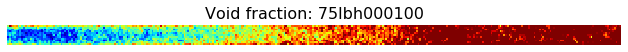

In [29]:
plot_channel_image(img, title='Void fraction: {}'.format(L))


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


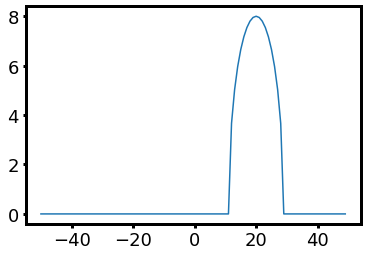

In [178]:

x = np.arange(100)-50
y = multi_cross_sec(x, 20, 9, 4, 60, 4, 5)
plt.plot(x,y)
plt.show()


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_laun

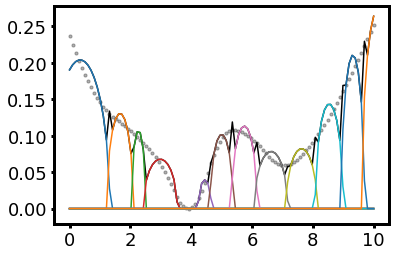

In [176]:
def get_guess(x, y, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed. 
    """
    guess = []
    low_bounds = []
    high_bounds = []
    center_increment = (np.max(x)-np.min(x))/n
    
    for g in range(n):
        guess += [
            center_increment*(g+1), # center x-coordinate
            (np.max(x)-np.min(x))/(2*n), # x-radius
            np.mean(y)/2] # y-radius
        low_bounds += []
        high_bounds += []
    return guess, (low_bounds, high_bounds)

for i in range(1):
    
    profile = resample(np.column_stack((np.arange(img.shape[0]), img[:, i]/250)))
    profile[:, 1] -= np.min(profile[:, 1])
    
    plt.scatter(profile[:, 0], profile[:, 1], alpha=0.3, s=10, c='k')

    guess, bounds = get_guess(profile[:, 0], profile[:, 1], 12)
    '''
    guess = [5, 2, 0.3,
             1.5, 2, 0.3,
             9, 2, 0.3,
             7, 2, 0.3,
             3, 2, 0.3]
    '''
    
    popt, _ = curve_fit(multi_cross_sec, profile[:, 0], profile[:, 1], p0=guess)
    fit = multi_cross_sec(profile[:, 0], *popt)
    
    plt.plot(profile[:, 0], fit, c='k')

    
    for p in range(0, len(popt), 3):
        fit0 = multi_cross_sec(profile[:, 0], *popt[p:p+3])
        plt.plot(profile[:, 0], fit0)
        
plt.show()

In [155]:
popt

array([0.95910173, 2.23149941, 0.3442022 , 4.04656038, 1.02967714,
       0.28143079, 6.00023017, 1.09268875, 0.32067694, 8.21094175,
       1.241245  , 0.33651392, 9.77718517, 0.43463724, 0.38993289])

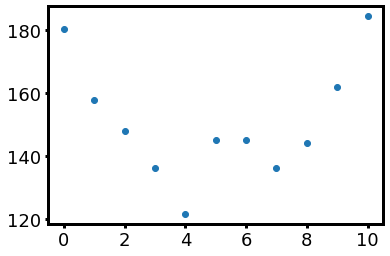

In [156]:
x_coords = np.arange(img.shape[0])
profile = img[:, i]

plt.scatter(x_coords, profile)

plt.show()

In [41]:
'''
starttime = time()

# loop over each image
for L in list(model_info['channels']):

    # get target image to model
    measured_image = model_info['channels'][L]['img_voidfrac']

    # get list of channel index coordinates and potential bubbles
    channel_coords = get_channel(measured_image.shape)
    bub_dict = get_bubbles(model_info, measured_image)

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'flowrate': model_info['channels'][L]['flowrate'],
        'temp': model_info['channels'][L]['temp'],
        'img_model': np.zeros_like(measured_image),
        'img_voidfrac': measured_image,
        'cent': [],
        'rad': []}
    
    # pixels to add to each bubble as a fluid buffer
    buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']
    
    # loop over each bubble to try and fit into the channel
    for i in range(len(bub_dict['rad'])):

        # get z-profile of new bubble
        bub_profile = 2*np.sqrt(bub_dict['rad_squared'][i]
                                - np.square(channel_coords[:, 0]-bub_dict['x'][i])
                                - np.square(channel_coords[:, 1]-bub_dict['y'][i])) + buffer_pixels


        # convert nan to 0 and reshape to channel size
        bub_profile = np.where(np.isnan(bub_profile),
                               0, bub_profile).reshape(sim['img_model'].shape)


        # add new bubble to channel if it will fit
        if np.all(sim['img_model'] + bub_profile <= 1.02*sim['img_voidfrac']):
            sim['img_model'] += bub_profile
            sim['rad'].append(bub_dict['rad'][i])
            sim['cent'].append([bub_dict['x'][i], bub_dict['y'][i]])


    # get total avg error between image and model
    tot_err = np.mean(np.abs((sim['img_model']-sim['img_voidfrac'])/sim['img_voidfrac']))*100
    sim['percent_error'] = round(tot_err, 2)
    
    # save model to file on local machine
    save_model_path = os.path.join(os.getcwd(), 'models', L + '__model.npy')
    np.save(save_model_path, sim)
    
    # show original channel image
    plot_channel_image(sim['img_voidfrac'], title='Measured image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # show simulated channel image
    plot_channel_image(sim['img_model'], title='Simulated image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # print statistics of model
    print('bubbles in channel: {}'.format(len(sim['rad'])))
    print('total runtime (min): {}'.format(round((time() - starttime)/60,1)))
    print('simulation error (%): {}'.format(round(tot_err, 2)))
    print('--------------------------------------------------------------\n')
'''

"\nstarttime = time()\n\n# loop over each image\nfor L in list(model_info['channels']):\n\n    # get target image to model\n    measured_image = model_info['channels'][L]['img_voidfrac']\n\n    # get list of channel index coordinates and potential bubbles\n    channel_coords = get_channel(measured_image.shape)\n    bub_dict = get_bubbles(model_info, measured_image)\n\n    # simulate empty channel to populate with simulated bubbles\n    sim = {\n        'label': L,\n        'flowrate': model_info['channels'][L]['flowrate'],\n        'temp': model_info['channels'][L]['temp'],\n        'img_model': np.zeros_like(measured_image),\n        'img_voidfrac': measured_image,\n        'cent': [],\n        'rad': []}\n    \n    # pixels to add to each bubble as a fluid buffer\n    buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']\n    \n    # loop over each bubble to try and fit into the channel\n    for i in range(len(bub_dict['rad'])):\n\n        # get z-profile of new bubble\n

In [40]:
17*344

5848

## Model the void fraction in each channel image

Now we use Monte Carlo methods to construct possible bubble configurations
in the channel which will approximate the experimentally-measured
void fraction in each image. This is carried out by beginning at the first
column of pixlels and adding disks (cross-sectional slices) of bubbles.

Then we progress to the next pixel column and add new cross sections
based on which disks were present in the preceeding pixel column.

First we import the trimmed channel images from the dictionary file.
Then we loop over each image, construct an empty simulated channel, and
incrementally add disks to it.

The simulated channel models are saved to file in the *\models* directory.
Each model is saved as a Python dictionary and corresponds
to a particular channel image. The model includes:
* **label**: (filename) of the original channel image
* **img_model**: simulated channel image
* **img_voidfrac**: measured void fraction image
* **cent**: the centers of the simulated bubbles, in ordered pairs (x, y)
* **rad**: the radii of the simulated bubbles
* **percent_error**: total percent error between the measured channel image and the simulated channel image